# Merge and read csv_files

In [1]:
import pandas as pd
import glob
import os

# Path to your folder
folder_path = "../../csv_files"

# Find all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Read and concatenate all CSVs into one DataFrame
df = pd.concat((pd.read_csv(file) for file in csv_files), ignore_index=True)

# Keep only rows where Experiment == "SR"
df = df[df["Experiment"] == "SR"]

# Show the combined DataFrame
print(df.head())

   Name Experiment  Trial                       Sequence         Recall
20  liv         SR      1  b q v t z d e s x r h p f i g  b g q t z d e
21  liv         SR      2  n d r z u c e g x k h i v a f    n d r z q e
22  liv         SR      3  f t l n j v r a h i x p k m z    f t n l j v
23  liv         SR      4  r c u l h z s a v q j n g x k  r t u l z s a
24  liv         SR      5  k l i v c d n m a e o p b y g  k l i v c d n


In [2]:
df["points"] = 0   # initialize column
df["fails"] = [[] for _ in range(len(df))]  # initialize fails as empty lists

for idx, row in df.iterrows():
    seq = row["Sequence"].split()
    rec = row["Recall"].split()
    
    points = 0
    fails = []
    mistake_found = False
    
    for s, r in zip(seq, rec):
        if not mistake_found and s == r:
            points += 1
        elif s != r:
            fails.append((s, r))
            mistake_found = True  # lock the points counter
    
    # save results back into df
    df.at[idx, "points"] = points
    df.at[idx, "fails"] = fails


df.head(10)

,Name,Experiment,Trial,Sequence,Recall,points,fails
20,liv,SR,1,b q v t z d e s x r h p f i g,b g q t z d e,1,"[(q, g), (v, q)]"
21,liv,SR,2,n d r z u c e g x k h i v a f,n d r z q e,4,"[(u, q), (c, e)]"
22,liv,SR,3,f t l n j v r a h i x p k m z,f t n l j v,2,"[(l, n), (n, l)]"
23,liv,SR,4,r c u l h z s a v q j n g x k,r t u l z s a,1,"[(c, t), (h, z), (z, s), (s, a)]"
24,liv,SR,5,k l i v c d n m a e o p b y g,k l i v c d n,7,[]
25,liv,SR,6,h g r z m l o f e c i u q v k,h g r z m l o f,8,[]
26,liv,SR,7,b d z f i v l r a n e y m p j,b l z f m v i n,1,"[(d, l), (i, m), (l, i), (r, n)]"
27,liv,SR,8,k l a n u q d e v c s x z g m,k l a n u q d e v c l s x,10,"[(s, l), (x, s), (z, x)]"
28,liv,SR,9,s e q a z j c y v r d o t l f,k l a n e q j c,0,"[(s, k), (e, l), (q, a), (a, n), (z, e), (j, q..."
29,liv,SR,10,s d a r b l c t h j y x z q o,s d a r b l c t h,9,[]


# Confusion matrix

[('q', 'g'), ('u', 'q'), ('l', 'n'), ('c', 't'), ('d', 'l'), ('s', 'l'), ('s', 'o'), ('u', 'o'), ('u', 'n'), ('g', 'a'), ('u', 'o'), ('a', 'u'), ('a', 'g'), ('v', 'c'), ('t', 'u'), ('o', 'u'), ('c', 'v'), ('k', 'f'), ('r', 'i'), ('f', 'u'), ('l', 'n'), ('b', 'j'), ('z', 'm'), ('n', 'u'), ('g', 'z'), ('s', 'z'), ('e', 'n'), ('n', 'i'), ('e', 'x'), ('s', 'x'), ('u', 'i'), ('h', 'k'), ('l', 'j'), ('o', 'h'), ('c', 'k'), ('c', 'p'), ('k', 'q'), ('h', 'p'), ('p', 'b'), ('j', 'l'), ('y', 'l'), ('k', 'z'), ('a', 'k'), ('z', 'k'), ('s', 'i'), ('a', 'r'), ('a', 'r'), ('y', 'i'), ('p', 's'), ('y', 'i'), ('t', 'b'), ('q', 'b'), ('v', 'k')]


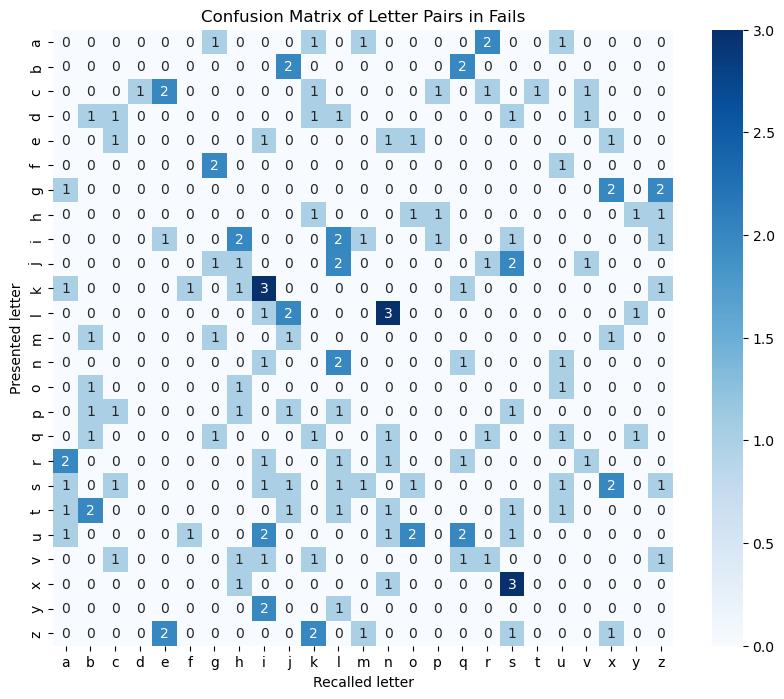

In [6]:
from collections import Counter
import seaborn as sns

import matplotlib.pyplot as plt

# Flatten all (s, r) pairs in fails column
all_fails = [pair for sublist in df["fails"] for pair in sublist]
first_fails = [sublist[0] for sublist in df["fails"] if sublist]
print(first_fails)

# Count occurrences of each (s, r) pair
fail_counts = Counter(all_fails)

# Get sorted unique letters for axis labels
letters = sorted(set([s for s, _ in all_fails] + [r for _, r in all_fails]))

# Create confusion matrix DataFrame
conf_matrix = pd.DataFrame(0, index=letters, columns=letters)
for (s, r), count in fail_counts.items():
    conf_matrix.loc[s, r] = count

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Recalled letter")
plt.ylabel("Presented letter")
plt.title("Confusion Matrix of Letter Pairs in Fails")
plt.show()

## Points analysis

In [4]:
import scipy.stats as stats
import numpy as np
points=df['points'].to_numpy()
print(np.mean(points))
stats.ttest_1samp(points,popmean= np.mean(points)).confidence_interval(confidence_level=0.95)

3.8


ConfidenceInterval(low=3.186297713541645, high=4.413702286458355)

In [5]:
df=df[df['points']!=0]
points=df['points'].to_numpy()
print(np.mean(points))
stats.ttest_1samp(points,popmean= np.mean(points)).confidence_interval(confidence_level=0.95)

4.108108108108108


ConfidenceInterval(low=3.4974596953575934, high=4.718756520858622)

### Only first fails